# Prediction of wine quality analysis using different algorithms

The purpose is here to be able to modelise the quality score system and be able to predict new scores with real data

In [157]:
import pandas as pd
import seaborn as sns 
import numpy as np

from xgboost import XGBClassifier

from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
%matplotlib inline

### A look at the data

Let's have a look at the data here :)

In [158]:
df = pd.read_csv('winequality-red.csv')
df = shuffle(df)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1006,9.1,0.29,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
427,9.5,0.78,0.22,1.90,0.077,6.0,32.0,0.99880,3.26,0.56,10.6,6
1072,7.2,0.35,0.26,1.80,0.083,33.0,75.0,0.99680,3.40,0.58,9.5,6
154,7.1,0.43,0.42,5.50,0.070,29.0,129.0,0.99730,3.42,0.72,10.5,5
1223,10.5,0.36,0.47,2.20,0.074,9.0,23.0,0.99638,3.23,0.76,12.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...
832,10.4,0.44,0.42,1.50,0.145,34.0,48.0,0.99832,3.38,0.86,9.9,3
389,9.6,0.38,0.31,2.50,0.096,16.0,49.0,0.99820,3.19,0.70,10.0,7
434,10.4,0.41,0.55,3.20,0.076,22.0,54.0,0.99960,3.15,0.89,9.9,6
171,8.0,0.42,0.17,2.00,0.073,6.0,18.0,0.99720,3.29,0.61,9.2,6


In [159]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


The datatset is small but t should ne enough to draw conclusions on it.

<AxesSubplot:>

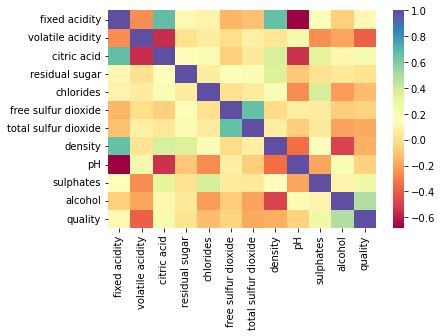

In [160]:
corr  = df.corr()
sns.heatmap(corr, cmap='Spectral')

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599 entries, 1006 to 1318
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 162.4 KB


### Proccessing of the data

Here we will process the data, because one the class is underrepresented.
For this, we will use the oversampling technique SMOTE
Then we'll apply a normalization technique to reduce importance of outliers and be able to use the dataset on gradient descent algorithms

In [162]:
X = df.drop(['quality'],axis=1).values
y = df['quality'].values

oversample = SMOTE()
X, y  = oversample.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [163]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### ANN
We'll first use an ANN to modelise the data

In [164]:
ann = Sequential([
  layers.Dense(units=32, activation='relu'),
  layers.Dense(units=32, activation='relu'),
  layers.Dense(units=32, activation='softmax'),
  layers.Dense(units=1)
])

ann.compile(loss='mse', optimizer='adam')

In [165]:
ann.fit(
    x=X_train,
    y=y_train, 
    epochs=600, 
    batch_size=32,
    validation_data=(X_test,y_test),
    callbacks=EarlyStopping(monitor='val_loss',patience=4))

Epoch 1/600
86/86 [==============================] - 1s 2ms/step - loss: 29.8602 - val_loss: 27.3364
Epoch 2/600
86/86 [==============================] - 0s 1ms/step - loss: 26.1196 - val_loss: 24.6354
Epoch 3/600
86/86 [==============================] - 0s 1ms/step - loss: 23.8633 - val_loss: 22.7405
Epoch 4/600
86/86 [==============================] - 0s 1ms/step - loss: 22.1339 - val_loss: 21.1364
Epoch 5/600
86/86 [==============================] - 0s 1ms/step - loss: 20.6057 - val_loss: 19.6915
Epoch 6/600
86/86 [==============================] - 0s 1ms/step - loss: 19.2099 - val_loss: 18.3531
Epoch 7/600
86/86 [==============================] - 0s 1ms/step - loss: 17.9179 - val_loss: 17.1079
Epoch 8/600
86/86 [==============================] - 0s 1ms/step - loss: 16.7161 - val_loss: 15.9541
Epoch 9/600
86/86 [==============================] - 0s 1ms/step - loss: 15.5937 - val_loss: 14.8761
Epoch 10/600
86/86 [==============================] - 0s 1ms/step - loss: 14.5451 - val_los

In [166]:
ann.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 32)                384       
                                                                 
 dense_95 (Dense)            (None, 32)                1056      
                                                                 
 dense_96 (Dense)            (None, 32)                1056      
                                                                 
 dense_97 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,529
Trainable params: 2,529
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

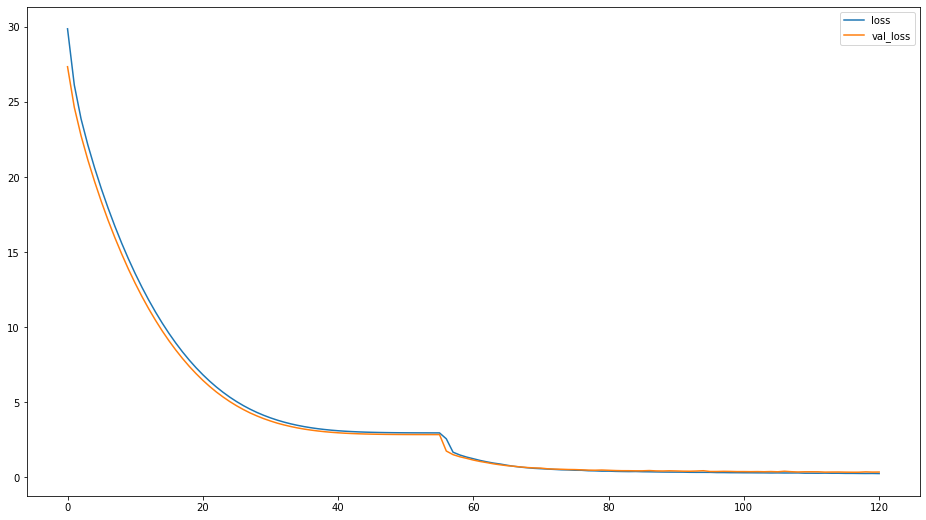

In [167]:
pd.DataFrame(ann.history.history).plot(figsize=(16,9))

In [168]:
predictions = ann.predict(X_test)

predictions

43/43 [==============================] - 0s 861us/step


array([[5.1670594],
       [6.5168657],
       [5.7722683],
       ...,
       [4.2747245],
       [5.899273 ],
       [4.74747  ]], dtype=float32)

Text(0, 0.5, 'Actual Values')

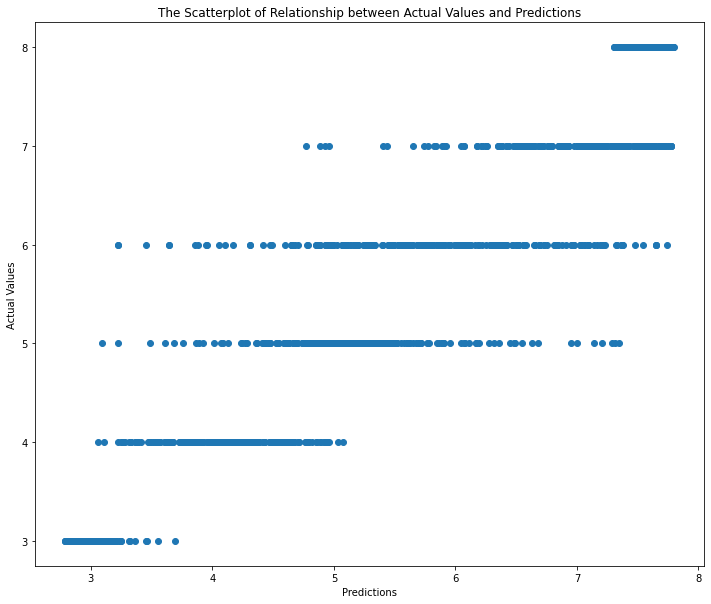

In [169]:
plt.figure(figsize=(12,10))
plt.scatter(np.ravel(predictions),y_test)
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")

In [170]:
print("MAE:",metrics.mean_absolute_error(y_test,predictions))
print ("MSE:",metrics.mean_squared_error(y_test,predictions))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE: 0.4267268999140735
MSE: 0.3498843532246438
RMSE: 0.591510230870645


In [171]:
metrics.explained_variance_score(y_test, predictions)

0.877983703541352

In [172]:
from sklearn.metrics import *

for i in range(len(predictions)):
    predictions[i][0] = round(predictions[i][0])

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           3       0.90      0.99      0.94       220
           4       0.80      0.74      0.77       221
           5       0.57      0.64      0.61       230
           6       0.60      0.44      0.50       247
           7       0.57      0.59      0.58       213
           8       0.77      0.84      0.80       218

    accuracy                           0.70      1349
   macro avg       0.70      0.71      0.70      1349
weighted avg       0.70      0.70      0.70      1349



### XGBoost

Second algorithmused is  XGBoost Regressor and Classifier (both)

In [173]:
import xgboost as  xgb

model = xgb.XGBRegressor()

model.fit(X_train,y_train)

preds = model.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.480025


In [174]:
metrics.explained_variance_score(y_test, preds)

0.918909523529255

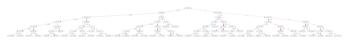

In [175]:
xgb.plot_tree(model, num_trees=2)
plt.show()

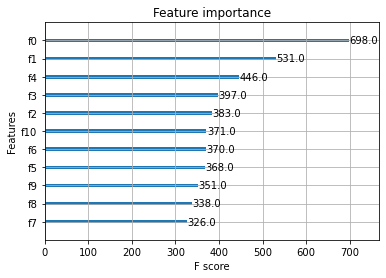

In [176]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [177]:
model2 = XGBClassifier(use_label_encoder=False)
model2.fit(X_train,y_train -3)

[17:18:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [178]:
preds2 = model2.predict(X_test)
score = metrics.accuracy_score(y_test-3, preds2)
print('Accuracy: %.3f' % score)

Accuracy: 0.855


In [179]:
print(classification_report(y_test-3,preds2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       220
           1       0.93      0.95      0.94       221
           2       0.73      0.75      0.74       230
           3       0.71      0.57      0.63       247
           4       0.81      0.92      0.86       213
           5       0.95      1.00      0.97       218

    accuracy                           0.86      1349
   macro avg       0.85      0.86      0.86      1349
weighted avg       0.85      0.86      0.85      1349



## Conclusion

The best algotrithm used here  is XGBoost  classifier with an accuracy of 0.86 and a F1 score of 0.97